## 1. Import the necessary libraries and packages

In [1]:
import os
import os.path
from pathlib import Path
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import plotly
import k3d
import glob
import time

print('Successfully imported all libraries')

Successfully imported all libraries


## 2. Calibration: Choose between custom calibration+Optimization and Pseudo (hardware) based calibration

In [2]:
from camera_calibration import choose_calibration_params


"""
args: choice = 1 : uses hardware to compute the calibration parameters
args: choice = 2 : uses an analytic approach with reference images (dollar bills)"""


K, Kp = choose_calibration_params(choice=1)        # based on physical properties
# K, Kp = choose_calibration_params(choice=2)      # alternatively based on optimization


print('K Calibration matrix: (physically configured using Pseudo Calibration)')
print(K)

Successfully imported all libraries
K Calibration matrix: (physically configured using Pseudo Calibration)
[[4.16535433e+02 0.00000000e+00 1.51200000e+03]
 [0.00000000e+00 4.16535433e+02 2.01600000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


## 3. Select pairs of "views" to be considered for the reconstruction and erase the background features using a pretrained ResNet based Segmentation Model

In [3]:
from erase_background import erase_bg


test = []

for i in np.arange(1,8):
    
    path = os.path.normpath("data/new_test/IMG_%d.JPG" % (i))
    
    img  = cv.imread(path)
    # img  = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    mask = erase_bg(path, 'person')
    
    if path[-3:] == 'jpg':               # rotate the mask by 90 deg if the img is of jpg format
        mask = cv.rotate(mask, cv.ROTATE_90_COUNTERCLOCKWISE)
    
    img  = (img * np.expand_dims(mask, axis=2)).astype(np.uint8)    # used to be uint8...
    
    test.append(img)
    
    """
    plt.subplots(1,2)
    plt.subplot(121)
    plt.imshow(mask)
    plt.subplot(122)
    plt.imshow(test[-1])
    plt.show()"""

## 4. For every pair of images of the 8 views in the previous cell:

In [4]:
## a) Detect "feature points" using SURF / Akaze / SIFT
## b) Match features between both views
## c) Use the best matches to compute a Homography matrix taking the points from the first of the two views to the second one
## d) Store the "uncalibrated" feature points of every pair of images
## e) Use the uncalibrated points to compute the "fundamental matrix" F for this pair of views
## f) Use the calibration matrix K, (Kprime) and F to compute the Essential matrix E




---------------------------------------------------------------------------------------------------


Current pair of image indices:  0  and  1

Akaze feature matcher function invoked!


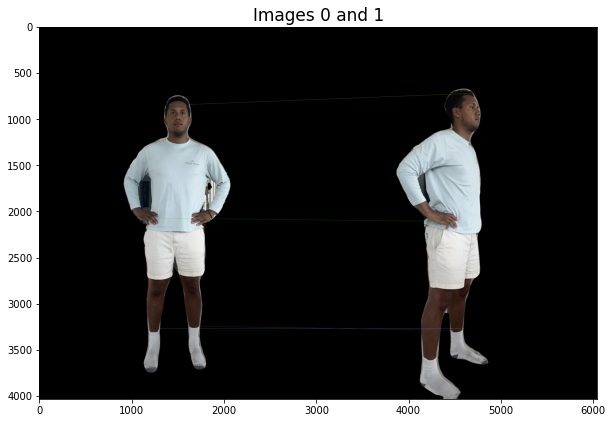


ANOMALY: wrt . This was NOT an H == None condition! F =  None

This pair of views will not be considered for a point cloud



---------------------------------------------------------------------------------------------------


Current pair of image indices:  1  and  2

Akaze feature matcher function invoked!


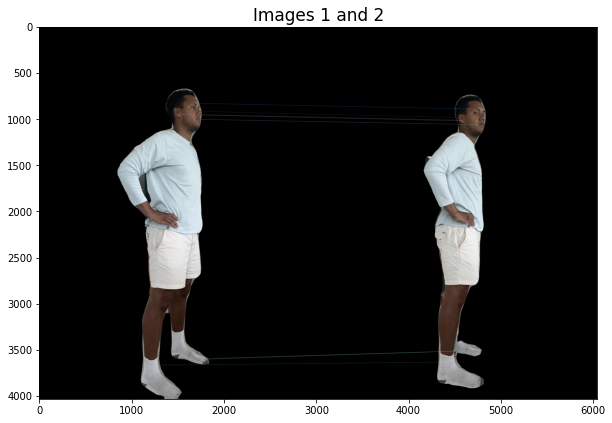




---------------------------------------------------------------------------------------------------


Current pair of image indices:  2  and  3

Akaze feature matcher function invoked!
Not enough matches are found - 1/4

H was not calculated correctly due to insufficient features. H =  None

This pair of views will not be considered for a point cloud



---------------------------------------------------------------------------------------------------


Current pair of image indices:  3  and  4

Akaze feature matcher function invoked!


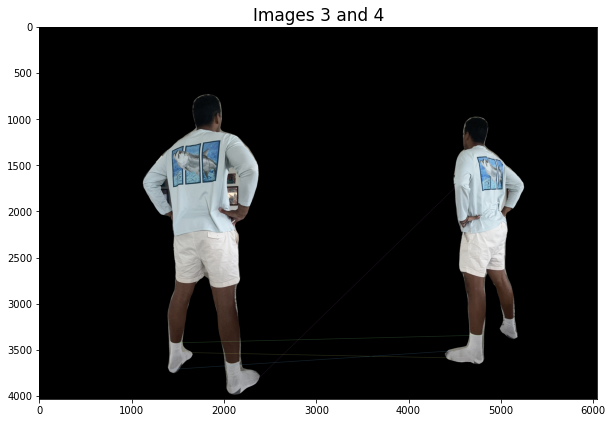


ANOMALY: wrt . This was NOT an H == None condition! F =  None

This pair of views will not be considered for a point cloud



---------------------------------------------------------------------------------------------------


Current pair of image indices:  4  and  5

Akaze feature matcher function invoked!


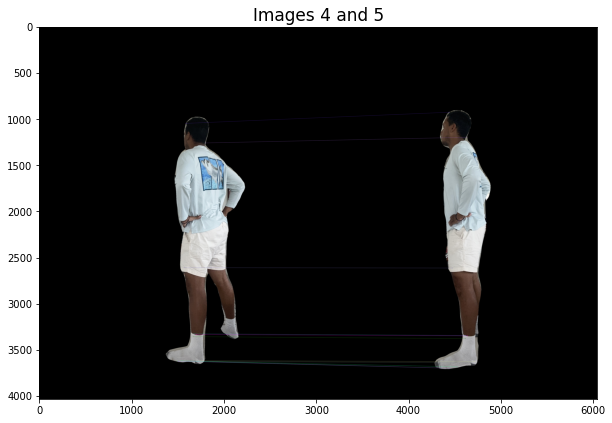




---------------------------------------------------------------------------------------------------


Current pair of image indices:  5  and  6

Akaze feature matcher function invoked!


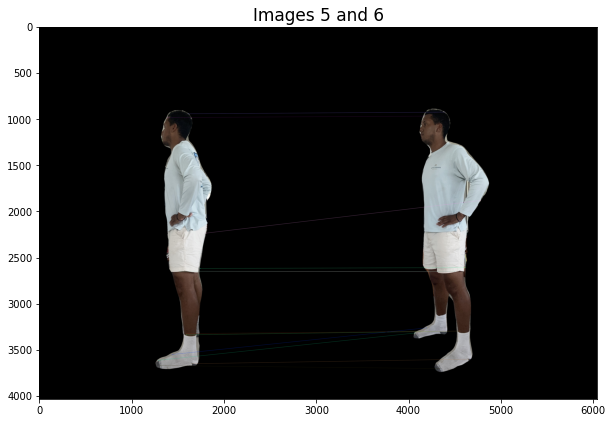




---------------------------------------------------------------------------------------------------


Current pair of image indices:  6  and  0

Akaze feature matcher function invoked!


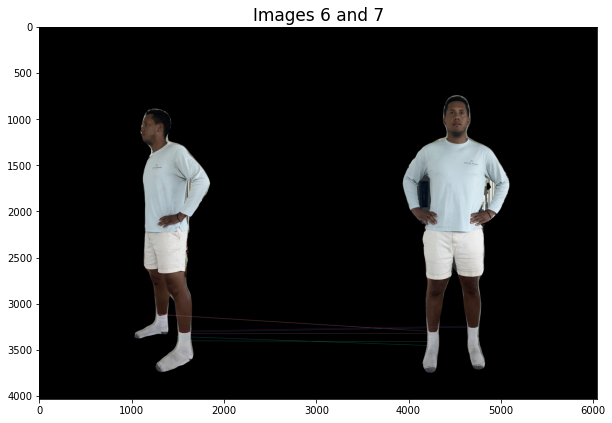

In [5]:
from keypoint_detectionANDmatching import sift_matching, akaze_matching
from tqdm import tqdm


H_mats = [];       H_inv_mats = []
src_uncal = [];    src_cal = []
dst_uncal = [];    dst_cal = []
kp_src = []
kp_dst = []
F_mats = [];       E_mats = []
test_pairs = []
insuf_matches = 0
degenerate_F = 0


for i in range(7):
    
    
    print('\n\n')
    print('---------------------------------------------------------------------------------------------------')
    print('\n\nCurrent pair of image indices: ', i, ' and ', np.mod(i+1,7))
    
    
    # 1. Use a Key-point based feature matching technique and compute the homographies and keypoints for
    # every pair of images   
    H, H_inv, uncalib_i, uncalib_j, kp_i, kp_j, good = akaze_matching(test[i], test[np.mod(i+1,7)], i)
    
    if not bool(np.asarray(H).shape):
        print('\nH was not calculated correctly due to insufficient features. H = ', H)
        print('\nThis pair of views will not be considered for a point cloud')
        insuf_matches += 1
        continue    # Current pair did not find enough matching pairs to be able to compute a homography
    
    
    
    # 2. Calculate the Fundamental matrix F for the uncalibrated pts from the current pair of views
    F, inlier_status = cv.findFundamentalMat(uncalib_i, uncalib_j, cv.FM_RANSAC, ransacReprojThreshold=4, confidence=0.999, maxIters=10000)
    if not bool(np.asarray(F).shape):
        print('\nANOMALY: wrt 'F'. This was NOT an H == None condition! F = ', F)
        print('\nThis pair of views will not be considered for a point cloud')
        degenerate_F += 1
        continue    # F was not computed due to rank insufficiency
        
    
    
    ## 3. Compute the source and destination points in float32 type for use during rectification...
    src = np.int32(uncalib_i[:, :2])
    src = uncalib_i[inlier_status.ravel() == 1]      # only choose inlier points among the src points!
    dst = np.int32(uncalib_j[:, :2])
    dst = uncalib_j[inlier_status.ravel() == 1]      # only choose inlier points among the dst points!
    
    
    
    ## 4. Calibrate the uncalibrated points by multiplying them with the intrinsics matrices K and Kprime
    calib_src = np.matmul(K , np.hstack((src.squeeze(1), np.ones((len(src),1)))).T).T     # multiplying K with the uncalib pts to "calibrate" them
    calib_dst = np.matmul(Kp, np.hstack((dst.squeeze(1), np.ones((len(dst),1)))).T).T     # multiplying K with the uncalib pts to "calibrate" them
    
    
    
    ## 5. Compute the Essential matrix E using K, Kprime and F
    E = Kp.T @ F @ K
    
    
    
    ## 6. Append the information obtained for each pair of images to bigger lists
    H_mats.append(H);      H_inv_mats.append(H_inv)     # Homography and inverse homography matrices bw the current pair of images
    src_uncal.append(src)                               # uncalibrated feature points from the first img
    dst_uncal.append(dst)                               # uncalibrated feature points from the second img
    src_cal.append(calib_src)                           # calibrated feature points from the first img
    dst_cal.append(calib_dst)                           # calibrated feature points from the first img
    F_mats.append(F)                                    # Fundamental matrix for this pair of images
    E_mats.append(E)                                    # Essential matrix for this pair of images
    test_pairs.append([test[i], test[np.mod(i+1,7)]])   # Pair of test images

In [6]:
print('Preprocessing outcome')
print('=====================')
print('\n')
print('Total number of image pairs considered           : {}'.format(int(len(test))))
print('Number of image pairs which produced H/F matrices: {} / {}'.format(int(len(test_pairs)), int(len(test))))
print('Number of cases with insufficient matches        : {} / {}'.format(int(insuf_matches), int(len(test))))
print('Number of cases with degeneracy in F matrix      : {} / {}'.format(int(degenerate_F), int(len(test))))





Preprocessing outcome



Total number of image pairs considered           : 7
Number of image pairs which produced H/F matrices: 4 / 7
Number of cases with insufficient matches        : 1 / 7
Number of cases with degeneracy in F matrix      : 2 / 7


## 5. Rectification and Depth Map Generation

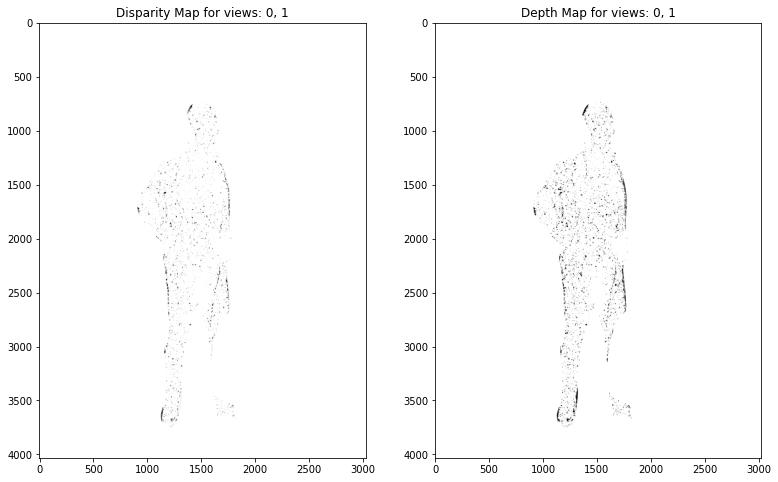

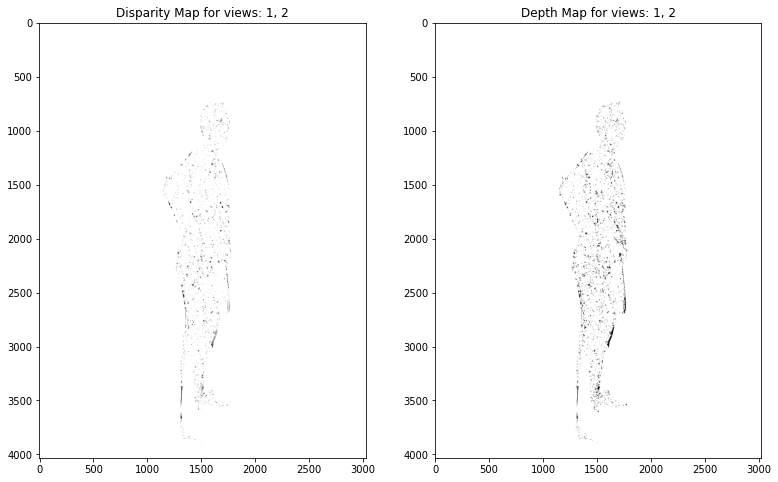

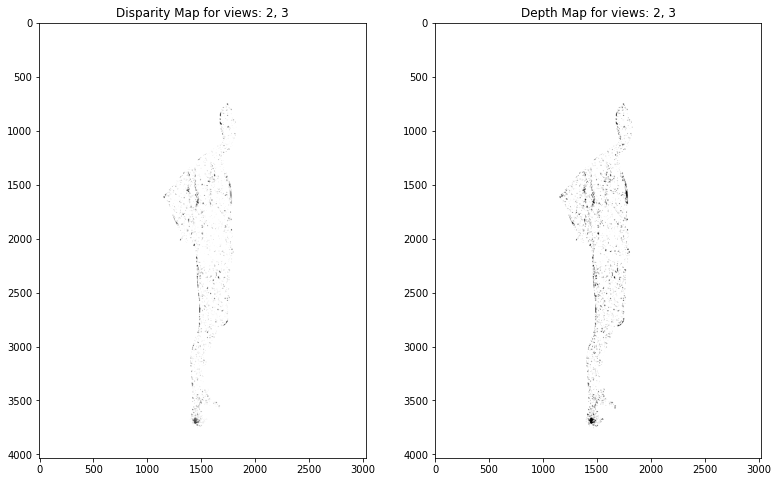

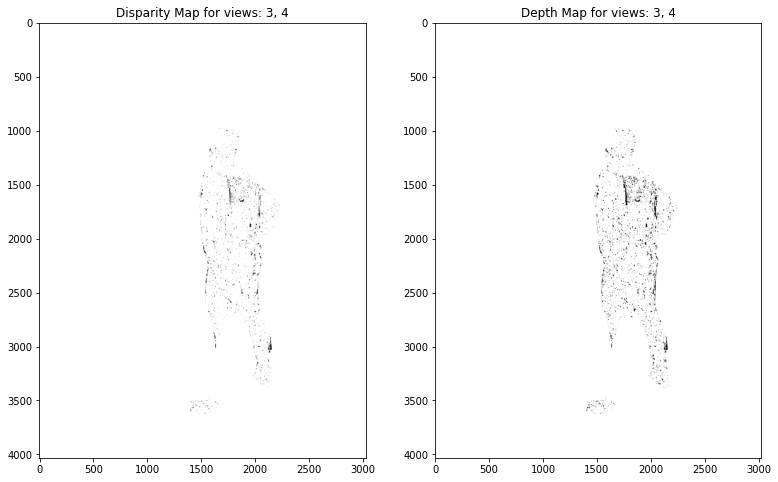

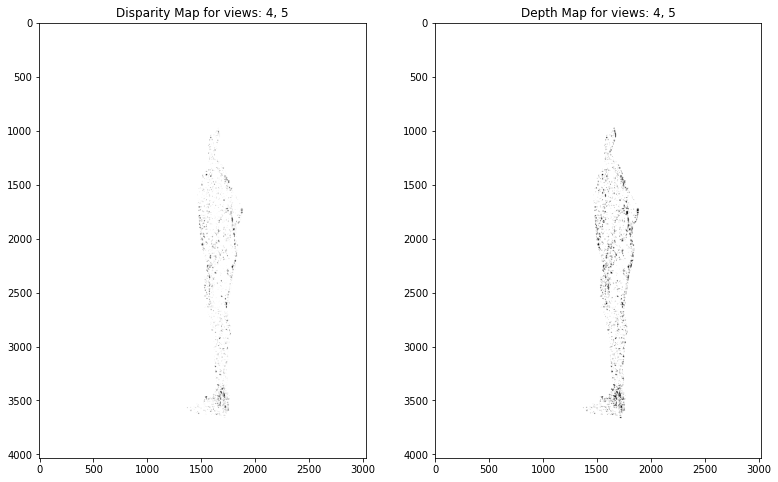

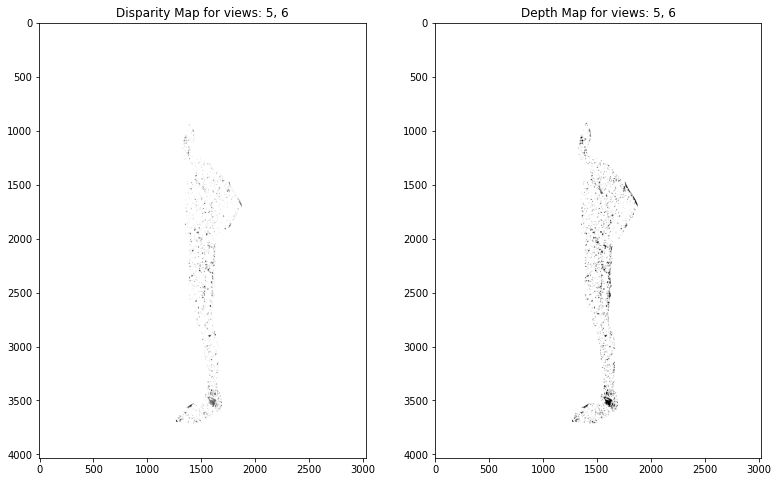

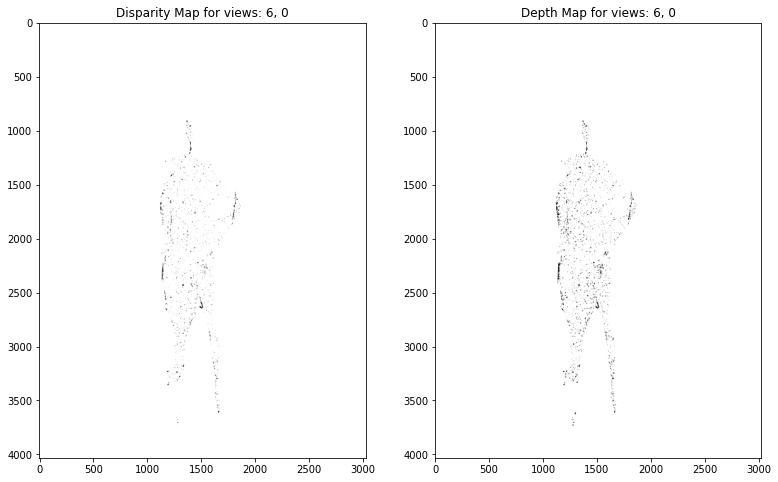

In [7]:
disp_maps = []
dep_maps  = []


for i in range(len(test)):
    
    ## 1. Convert the pair of views into grayscale and plot them for viewing
    # imgL = cv.cvtColor(test_pairs[i][0], cv.COLOR_BGR2GRAY)    # Using rectified images to generate depth maps
    # imgR = cv.cvtColor(test_pairs[i][1], cv.COLOR_BGR2GRAY)    # Using rectified images to generate depth maps
    imgL = cv.cvtColor(test[i], cv.COLOR_BGR2GRAY)    # Using un-rectified images to generate depth maps
    imgR = cv.cvtColor(test[np.mod(i+1,7)], cv.COLOR_BGR2GRAY)    # Using un-rectified images to generate depth maps
    
    """
    plt.subplots(1,2, figsize=(7,7))         # Plotting the two grayscale views of interest
    plt.subplot(121)
    plt.imshow(imgL, 'gray')
    plt.subplot(122)
    plt.imshow(imgR, 'gray'), plt.show()"""


    ## 2. Initializing the Stereo matching depth map generator and computing the disparity map
    stereo = cv.StereoBM.create(numDisparities=16, blockSize=15)
    disparity_map = stereo.compute( imgL, imgR)
    
    # depth_map = cv.stereoMatcher.compute(imgL, imgR)
    # disparity = 255 - stereo.compute(img1_L, img1_R)
    
    
    ## 3. Make sure the disparity values are all above 0 since we work with uncalibrated data
    min_disp = np.min(disparity_map)
    if min_disp < 0:
        disparity_map = disparity_map + abs(min_disp) + 1     # the range of values must begin with 0... or 1...?
    
    
    ## 4. Use the approximate translation distance of the camera between the two views to calculate the
    #     depth map from the disparity map
    B = 1000.0                                                # a foot and a half baseline distance
    depth_map = (K[0][0] * B) / (disparity_map)               # f * B / disp_map
    depth_map /= depth_map.max()
    
    
    ## 5. Plot the computed disparity and depth maps
    f, axs = plt.subplots(1, 2, figsize=(13, 8))
    
    axs[0] = plt.subplot(1, 2, 1)             
    axs[0].set_title('Disparity Map for views: {}, {}'.format(i, np.mod(i+1,7)))
    axs[0].imshow(255 - disparity_map, 'gray')                # The disparity map is displayed!
    
    axs[1] = plt.subplot(1, 2, 2)
    axs[1].set_title('Depth Map for views: {}, {}'.format(i, np.mod(i+1,7)))
    axs[1].imshow(depth_map, 'gray')                    # The normalized depth map is displayed!
    
    
    ## 6. Append the generated depth maps to a larger list
    disp_maps.append(disparity_map)
    dep_maps.append(depth_map)

### Compute the R and T matrices for both views

In [8]:
from recon3d import reconstruct3D

"""
P1s = []
P2s = []
Rs = []
Ts = []

for i in range(len(pairs_i)):
    
    print('For the {}-th pair of views:'.format(i))
    P1, P2, T, R = reconstruct3D(E_mats[i], calib_src[i], calib_dst[i])   # using E: the Essential matrix computed using the physically configured parameters for calibration
    
    print('Rotation matrix')
    print(R)
    print('Translation vector ')
    print(T)
    
    print('\n\n')
    
    P1s.append(P1)
    P2s.append(P2)
    Rs.append(R)
    Ts.append(T)
"""

"\nP1s = []\nP2s = []\nRs = []\nTs = []\n\nfor i in range(len(pairs_i)):\n    \n    print('For the {}-th pair of views:'.format(i))\n    P1, P2, T, R = reconstruct3D(E_mats[i], calib_src[i], calib_dst[i])   # using E: the Essential matrix computed using the physically configured parameters for calibration\n    \n    print('Rotation matrix')\n    print(R)\n    print('Translation vector ')\n    print(T)\n    \n    print('\n\n')\n    \n    P1s.append(P1)\n    P2s.append(P2)\n    Rs.append(R)\n    Ts.append(T)\n"

### Rectify one of the images in every pair

In [9]:
# Reference: https://stackoverflow.com/a/62607343
# Compute the two Homography matrices


for i in range(len(pairs_i)):
    
    im_left  = test[pairs_i[i][0]]
    im_right = test[pairs_i[i][1]]
    h1, w1 = im_left.shape[0] , im_left.shape[1]
    h2, w2 = im_right.shape[0], im_right.shape[1]

    """
    # _, H1, H2 = cv.stereoRectifyUncalibrated(src_pts_left, dst_pts_right, F, (w1, h1))
    _, H1, H2 = cv.stereoRectifyUncalibrated(src_pts_left, dst_pts_right, F, (w1, h1))
    
    print('H1 matrix: ')
    print('\nH2 matrix: ')
    """
    
    # Warping / Rectifying the left and right views
    left_rect  = cv.warpPerspective(im_left , H_inv_mats[i], (w1, h1))
    print('index: ', pairs_i[i][0])
    right_rect = cv.warpPerspective(im_right, np.eye(3), (w2, h2))          # H_inv???

    
    plt.subplots(1,2, figsize=(12,12))
    plt.subplot(121)
    plt.imshow(left_rect)
    plt.subplot(122)
    plt.imshow(right_rect)
    plt.show()
    
    """
    cv.imwrite("rect_left.png", left_rect)
    cv.imwrite("rect_right_inv.png", right_rect_inv)"""
    
    
    # Testing
    # right_rect = cv.warpPerspective(im_j, H, (w2, h2))
    # cv.imwrite("rect_right.png", right_rect)
    
    # Warping the reference image with H_inv
    # ref_rect = cv.warpPerspective(img3_right, H, (img3_right.shape[1], img3_right.shape[0]))

NameError: name 'pairs_i' is not defined